# CZ4042 Neural Networks & Deep Learning
## Assignment - 1: Part A, Question 2

> Gupta Jay  
> U1822549K  
> School of Computer Science and Engineering  
> Nanyang Technological University, Singapore  

## Imports

In [45]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [46]:
import pandas as pd
import numpy as np
import time

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [47]:
print(tf.__version__)

2.6.0


In [48]:
# Supress any warnings for clean presentation
import warnings
warnings.filterwarnings("ignore")

In [49]:
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [50]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

Split and scale dataset

In [51]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [52]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


In [53]:
def getModel(first_layer_activation, second_layer_activation):
    # Inputs -> Dense -> Dropout -> Dense (Output)
    model = keras.Sequential()
    model.add(layers.Dense(16, activation=first_layer_activation, input_dim=X_train.shape[1]))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(df['label'].nunique(), activation=second_layer_activation))
    return model

def getOptimizer():
    # Adam Optimizer (Default Parameters) -> Stochastic Gradient Descent
    optimizer = keras.optimizers.Adam()
    return optimizer

## Part A: Search for the Optimal Batch Size

> Reference for K-Fold Cross Validation: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

In [54]:
# Search Space
batch_sizes = [1, 4, 8, 16, 32, 64]

# Hyperparameters
epochs = 50
n_splits = 3
verbose = 0
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = getOptimizer()

histories_part_a = {} 

In [55]:
# 3-fold cross-validation on training partition
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

In [59]:
# Experiment on batch sizes
# Iterating through all batch sizes
for batch_size in batch_sizes:
    batch_specific_history = {}
    fold_counter = 1

    print("\nBatch Size: %0.0f" % batch_size)
    print("---------------")

    # Iterating through each split of training data
    for train, test in kfold.split(X_train, y_train):
        # Initialize model and fitting
        model = getModel("relu", "softmax")
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        history = model.fit(X_train[train], y_train[train], batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_train[test], y_train[test]))
        
        print("Training Complete: Fold %0.0f" % fold_counter)
        
        # Storing history of every k-fold
        batch_specific_history[fold_counter] = history
        fold_counter += 1

    # Storing history for every batch size
    histories_part_a[batch_size] = batch_specific_history


Batch Size: 1
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 4
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 8
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 16
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 32
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 64
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3


### Mean Cross-Validation Accuracies

In [60]:
accuracy_per_batch = []

# Iterating through all the batches
for batch_size in batch_sizes:
    accuracy_per_epoch = []
    
    # Extract k-fold history for a batch
    batch_histories = histories_part_a[batch_size]

    # Calculate mean across 3-fold accuracies for each epoch
    for i in range(epochs):
        accuracies = [batch_histories[1].history['val_accuracy'][i], batch_histories[2].history['val_accuracy'][i], batch_histories[3].history['val_accuracy'][i]]
        accuracy_per_epoch.append(np.mean(accuracies))

    # Store mean for each epoch, per batch    
    accuracy_per_batch.append(accuracy_per_epoch)

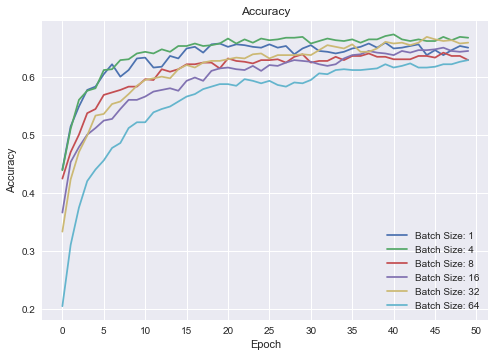

In [61]:
plt.style.use("seaborn")

# Plotting
for i in range(len(batch_sizes)):
    plt.plot(accuracy_per_batch[i])

# Labelling
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 50+1, 5.0))

# Legend for easy reading
plt.legend(['Batch Size: 1', 'Batch Size: 4', 'Batch Size: 8', 'Batch Size: 16', 'Batch Size: 32', 'Batch Size: 64'], loc='lower right')

## Part B: Median Time Taken to Train the Network

> Reference: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

In [62]:
# Callback to measure time for every epoch
class TimeHistory(keras.callbacks.Callback):
    # Initialize empty list of times when training begins
    def on_train_begin(self, logs={}):
        self.times = []

    # Start time on start of epoch
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    # End time and measure on end of epoch
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

# Callback
callbacks = [time_callback]

In [63]:
histories_part_b = {} 

# Experiment on batch sizes
# Iterating through all batch sizes
for batch_size in batch_sizes:
    batch_specific_history = {}
    fold_counter = 1

    print("\nBatch Size: %0.0f" % batch_size)
    print("---------------")
    
    # Iterating through each split of training data
    for train, test in kfold.split(X_train, y_train):
        # Initialize model and fitting
        model = getModel("relu", "softmax")
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        history = model.fit(X_train[train], y_train[train], callbacks=callbacks, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_train[test], y_train[test]))
        
        print("Training Complete: Fold %0.0f" % fold_counter)
        
        # Storing time history of every k-fold
        batch_specific_history[fold_counter] = time_callback.times
        fold_counter += 1

    # Store time history for every batch
    histories_part_b[batch_size] = batch_specific_history


Batch Size: 1
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 4
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 8
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 16
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 32
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Batch Size: 64
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3


In [64]:
time_per_batch = {}

# Iterating through all the batches
for batch_size in batch_sizes:
    time_per_epoch = []

    # Extract k-fold history for a batch
    batch_histories = histories_part_b[batch_size]

    # Calculate mean across 3-fold accuracies for each epoch
    for i in range(epochs):
        times = [batch_histories[1][i], batch_histories[2][i], batch_histories[3][i]]
        time_per_epoch.append(np.mean(times))
    
    # Store mean for each epoch, per batch
    time_per_batch[batch_size] = np.median(time_per_epoch)


In [65]:
# Convert the dictionary to a table representation
median_times = pd.DataFrame(time_per_batch.items(), columns=['Batch Size', 'Median Time (seconds)'])
median_times

,Batch Size,Median Time (seconds)
0,1,0.650596
1,4,0.195390
2,8,0.117447
3,16,0.077018
4,32,0.053871
5,64,0.045880


## Part C: Optimal Batch Size

**Optimal Batch Size**: `4`  

There are two main criteras I've used to select the optimal batch size:
* Mean Cross-Validation Accuracies `(part (a))`
* Mean Time Taken `(part (b))`

Firstly, The Mean Cross-Validation accuracies over the training epochs is lower for batch sizes of `16`, `32`, and `64`. For batch sizes `4` and `8`, the accuracies are similar to each other. However, the accuracy graph is highest and smoother for batch size of `4`. 

Secondly, I observe that the median time to train our model decreases significantly when the batch size is increased. This is reasonable as Stochastic Gradient Descent algorithm is more expensive, and for batch sizes greater than 1, Mini-Batch Gradient Descent algorithm will be expensive as well for smaller batch sizes. From batch size `1` to `4`, the `median time` reduces to more than `3` times.

## Part D: Mini-Batch Gradient Descent and Stochastic Gradient Descent

* **Stochastic Gradient Descent**: We consider `one` training example at a time to do forward and backward propagation and update the weights of the model. SGD is computationally expensive and requires more training time. Furthermore, since the weights are being updated so frequently, the loss/cost keeps fluctuating over the epochs. 


* **Mini-Batch Gradient Descent**: We consider `n` training examples (mini-batchs) at a time to do forward and backward propagation and update the weights of the model by taking the mean of gradients of each mini-batch. It is less computationally expensive than SGD. The average cost over the epochs keeps fluctuating as well due to frequent updates, however, the intensity of the fluctuations are lower than SGD. 

## Part E: Plot Train & Test Accuracies 

In [68]:
epochs = 50
verbose = 1

# Parameters for Optimal 2-layer network
batch_size = 4

loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = getOptimizer()

model = getModel("relu", "softmax")
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)

Epoch 1/50
175/175 [==============================] - 1s 1ms/step - loss: 2.3457 - accuracy: 0.1671 - val_loss: 2.0425 - val_accuracy: 0.2333
Epoch 2/50
175/175 [==============================] - 0s 996us/step - loss: 1.9300 - accuracy: 0.3114 - val_loss: 1.7870 - val_accuracy: 0.3800
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 1.7689 - accuracy: 0.3671 - val_loss: 1.5995 - val_accuracy: 0.4467
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 1.6418 - accuracy: 0.4114 - val_loss: 1.4935 - val_accuracy: 0.4633
Epoch 5/50
175/175 [==============================] - 0s 910us/step - loss: 1.4903 - accuracy: 0.4857 - val_loss: 1.4232 - val_accuracy: 0.4967
Epoch 6/50
175/175 [==============================] - 0s 873us/step - loss: 1.4140 - accuracy: 0.4871 - val_loss: 1.3582 - val_accuracy: 0.5433
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 1.3007 - accuracy: 0.5314 - val_loss: 1.3177 - val_accuracy: 0.5300


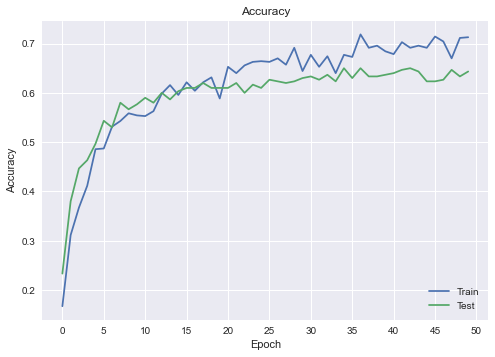

In [69]:
plt.style.use("seaborn")

# Extracting Train & Test Accuracy from model history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting
plt.plot(accuracy)
plt.plot(val_accuracy)

# Labelling
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 50+1, 5.0))

# Legend for easy reading
plt.legend(['Train', 'Test'], loc='lower right')

## End of Part A, Question 2. 